This notebook will be for the initial walk through and exploration of the data.

In [54]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)


In this project, you’re working for a client who wants to create a model that can predict the price of apartments in the city of Mexico (Distrito federal) — with a focus on apartments that cost less than $100,000 USD

# Prepare Data

## Import

There are over 5 datasets in total for this project, so instead of cleaning each of them individually, I will use a function that will automate the data importing and cleaning process.

In [52]:
def wrangle(filepath):
    # Read csv file into DataFrame
    df = pd.read_csv(filepath)
    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    # Create a borough column and drop the place_with_parent_names column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    # Drop columns with over 50% null values
    df.drop(columns=["floor" ,"expenses"], inplace=True)
    # Drop low and high cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    # Drop Leaky Columns
    df.drop(columns=["price", "price_aprox_local_currency","price_usd_per_m2", "price_per_m2"], inplace=True)
    # Drop columns with multicolinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

In [53]:
df = wrangle("mexico-city-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


For this project, I want to build a model for apartments in Mexico City  (`" Distrito Federal"`) that cost less than \$100,000. Looking at the first five rows of our DataFrame, I can already see that there properties that fall outside those parameters. So the first cleaning task is to remove those observations from the dataset. Since i'll be using a function to import and clean our data, i'll need to make changes there.

In [7]:
# Subset data: Apartments in "Distrito Federal", less than 100,000
mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
mask_apt = df["property_type"] == "apartment"
mask_price = df["price_aprox_usd"] < 100_000
df = df[mask_ba & mask_apt & mask_price]


In [8]:
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
11,sell,apartment,|Benito Juárez|Distrito Federal|México|,"23.634501,-102.552788",1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.228070,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...
14,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.36269,-99.150565",1260000.0,MXN,1248601.52,66384.96,NaN,103.0,NaN,12233.009709,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/onph_ven...
20,sell,apartment,|Iztacalco|Distrito Federal|México|,"19.4024128,-99.0953907",1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.857143,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...
21,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.35782,-99.149406",1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.500000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...


Size is an important factor in determining the price of apartments, so I will be considering that next.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 2 to 4622
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1405 non-null   object 
 1   property_type               1405 non-null   object 
 2   place_with_parent_names     1405 non-null   object 
 3   lat-lon                     1318 non-null   object 
 4   price                       1405 non-null   float64
 5   currency                    1405 non-null   object 
 6   price_aprox_local_currency  1405 non-null   float64
 7   price_aprox_usd             1405 non-null   float64
 8   surface_total_in_m2         185 non-null    float64
 9   surface_covered_in_m2       1366 non-null   float64
 10  price_usd_per_m2            128 non-null    float64
 11  price_per_m2                1352 non-null   float64
 12  floor                       0 non-null      float64
 13  rooms                       33 no

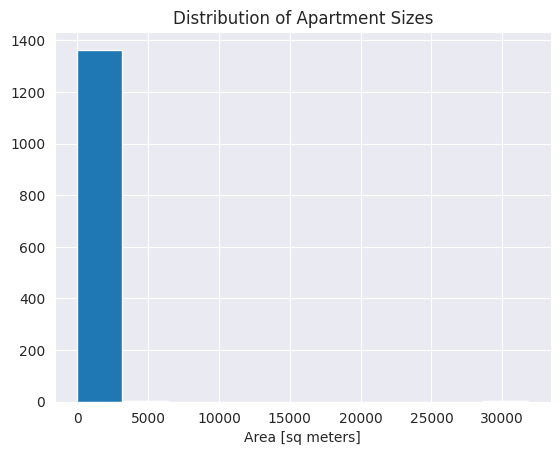

In [14]:
# Create a histogram of "surface_covered_in_m2 to see the distribution of apartment sizes
plt.hist(df["surface_covered_in_m2"])
plt.xlabel('Area [sq meters]')
plt.title("Distribution of Apartment Sizes");

This graph indicates the presence of outlers which can affect model performance, to further investigate, I will check the summary statistics of surface_covered_in_m2

In [16]:
df['surface_covered_in_m2'].describe()

count     1366.000000
mean       105.868228
std        875.098328
min          0.000000
25%         56.000000
50%         65.000000
75%         80.000000
max      31840.000000
Name: surface_covered_in_m2, dtype: float64

The summary statistics of surface_covered_in_m2 confirms that while most of the data are smaller than 85,000 square meters, some are several thousand meters. Best course of action is to remove them from the dataset and add the mask to the wrangle function above.

In [17]:
# Subset data: Remove outliers for "surface_covered_in_m2"
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
df = df[mask_area]

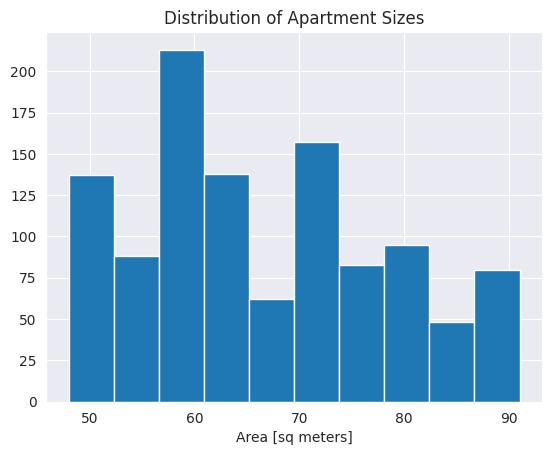

In [18]:
# Redo the histogram
plt.hist(df["surface_covered_in_m2"])
plt.xlabel('Area [sq meters]')
plt.title("Distribution of Apartment Sizes");

The "lat-lon" column should be split into individual columns and the "lat-lon" column should be dropped. This will also be added to the wrangle function above.

In [21]:
# Split "lat-lon" column
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
df.drop(columns="lat-lon", inplace=True)
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
11,sell,apartment,|Benito Juárez|Distrito Federal|México|,1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.228070,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...,23.634501,-102.552788
20,sell,apartment,|Iztacalco|Distrito Federal|México|,1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.857143,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...,19.402413,-99.095391
21,sell,apartment,|Benito Juárez|Distrito Federal|México|,1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.500000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...,19.357820,-99.149406
22,sell,apartment,|Azcapotzalco|Distrito Federal|México|,460000.0,MXN,455838.66,24235.78,NaN,60.0,NaN,7666.666667,NaN,NaN,NaN,http://prados-del-rosario.properati.com.mx/qba...,19.504985,-99.208557
26,sell,apartment,|Coyoacán|Distrito Federal|México|,1786800.0,MXN,1770635.95,94140.20,NaN,50.0,NaN,35736.000000,NaN,NaN,NaN,http://prado-churubusco.properati.com.mx/pm05_...,19.354219,-99.126244


In the place with parent names column, we can see that there are three distinct strings separated by a '|', they are "borough", "state" and "country" respectively.
A borough column would be very useful for the model, so I will create one and drop the place with parent names column.

In [25]:
# Create a borough column and drop the place_with_parent_names column
df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
df.drop(columns="place_with_parent_names", inplace=True)

For columns with null values, if there are over 50% null values in a column, it will be preferable if these columns are dropped.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1101 non-null   object 
 1   property_type               1101 non-null   object 
 2   price                       1101 non-null   float64
 3   currency                    1101 non-null   object 
 4   price_aprox_local_currency  1101 non-null   float64
 5   price_aprox_usd             1101 non-null   float64
 6   surface_total_in_m2         101 non-null    float64
 7   surface_covered_in_m2       1101 non-null   float64
 8   price_usd_per_m2            70 non-null     float64
 9   price_per_m2                1101 non-null   float64
 10  floor                       0 non-null      float64
 11  rooms                       6 non-null      float64
 12  expenses                    0 non-null      float64
 13  properati_url               1101

In [30]:
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.908265
surface_covered_in_m2         0.000000
price_usd_per_m2              0.936421
price_per_m2                  0.000000
floor                         1.000000
rooms                         0.994550
expenses                      1.000000
properati_url                 0.000000
lat                           0.054496
lon                           0.054496
borough                       0.000000
dtype: float64

In [ ]:
 # Drop columns with over 50% null values
df.drop(columns=["floor" ,"expenses"], inplace=True)

The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.


In [33]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            1
properati_url    1101
borough            14
dtype: int64

Here, we can see that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

It's also important for us to drop any columns that would constitute *leakage* , that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. Our target is "price_aprox_usd"

In [38]:
sorted(df.columns)

['borough',
 'lat',
 'lon',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

From the list above, the columns that will constitute leakage for our target are price, price_aprox_local_currency, price_per_m2 and price_usd_per_m2.

In [ ]:
# Drop Leaky Columns
df.drop(columns=["price", "price_aprox_local_currency","price_usd_per_m2", "price_per_m2"], inplace=True)


Finally, the last issue we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap

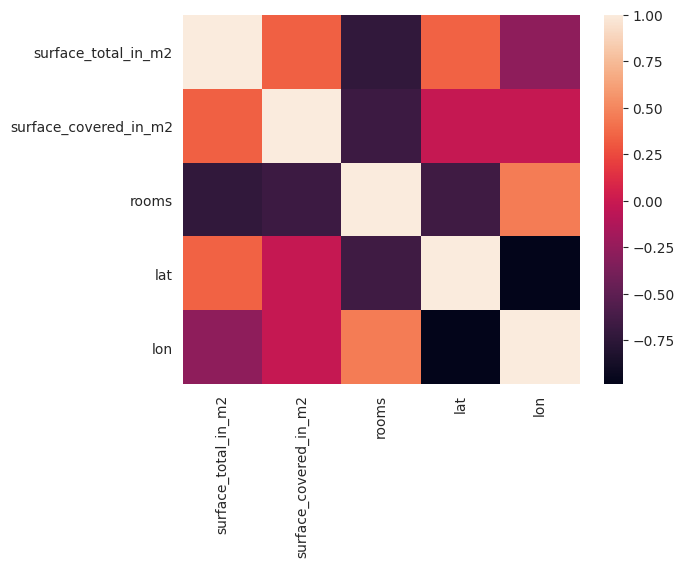

In [50]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);


From the heatmap above we can see that the columns with multicolinearity are "surface_total_in_m2" and "rooms" so they will be dropped.

In [51]:
# Drop columns with multicolinearity
df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)